In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ansersohaib566/df-raw-fydp")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'df-raw-fydp' dataset.
Path to dataset files: /kaggle/input/df-raw-fydp


In [ ]:
import pandas as pd
# Use the path printed from the kagglehub download
mydf = pd.read_csv(f"{path}/df_raw.csv", usecols=["lat", "lon", "mid_date", "v [m/yr]"])
display(mydf.head())

mid_date     lon    lat  v [m/yr]
0  2009-10-30 05:25:25.862885888  74.353  36.25      23.0
1  2004-08-28 05:30:18.351895040  74.353  36.25      79.0
2  2022-01-07 17:46:45.210608640  74.353  36.25       0.0
3  2021-08-08 05:46:39.210629120  74.353  36.25       5.0
4  2016-02-27 05:42:51.255436032  74.353  36.25       8.0

In [ ]:
import pandas as pd

# First ensure mid_date is a datetime type (if it isn't already)
mydf['mid_date'] = pd.to_datetime(mydf['mid_date'])

# Filter for dates between 2000-01-01 and 2021-12-31
filtered_df = mydf[(mydf['mid_date'] >= '2000-01-01') & (mydf['mid_date'] <= '2021-12-31')]

# Reduce the dataset size by keeping 40% of the filtered data
reduced_df = filtered_df.sample(frac=0.4, random_state=42) # Using a random_state for reproducibility

# Further reduce the dataset size by keeping 10% of the reduced data
final_reduced_df = reduced_df.sample(frac=0.1, random_state=42)

# Display the filtered and reduced data information
print(f"Original data points: {len(mydf)}")
print(f"Filtered data points: {len(filtered_df)}")
print(f"Reduced data points (40%): {len(reduced_df)}")
print(f"Final reduced data points (10% of 40%): {len(final_reduced_df)}")

# Now work with final_reduced_df for subsequent steps
filtered_df = final_reduced_df

# Display the head of the final reduced data
print("Head of the final reduced data:")
display(filtered_df.head())

# Save the final reduced data to a CSV file
final_reduced_df.to_csv('final_reduced_df.csv', index=False)
print("\nFinal reduced data saved to 'final_reduced_df.csv'")

Original data points: 73590934
Filtered data points: 44066563
Reduced data points (40%): 17626625
Final reduced data points (10% of 40%): 1762662
Head of the final reduced data:


mid_date      lon      lat  v [m/yr]
59949812 2018-10-27 05:33:16.039915008  74.5324  36.2515      22.0
53169881 2019-03-12 05:46:34.180823808  74.5095  36.2962       1.0
32975650 2010-05-18 05:25:19.460972032  74.4408  36.2947      11.0
69382332 2015-05-03 05:40:53.576491264  74.4866  36.2286     120.0
8618175  2014-01-17 05:34:00.208481024  74.3721  36.2872      24.0


Final reduced data saved to 'final_reduced_df.csv'


In [ ]:
# Initialize model, loss, optimizer, and scheduler
model = TransformerRegressor(
    input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler()

print("Model, criterion, optimizer, scheduler, and scaler initialized.")

Model, criterion, optimizer, scheduler, and scaler initialized.


/tmp/ipython-input-1791532739.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.

    """
    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    return data, scaler_X, scaler_y

class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerRegressor(nn.Module):
    """Transformer model for velocity prediction."""
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.

    Parameters:
    - model (nn.Module): The PyTorch model.

    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")

    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            pbar_train.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                pbar_val.set_postfix({'loss': val_loss / (pbar_val.n + 1), 'MAE': val_mae / (pbar_val.n + 1)})

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        scheduler.step(val_loss)

    return train_losses, val_losses, val_maes

In [ ]:
# Call the load_and_preprocess_data function
data, scaler_X, scaler_y = load_and_preprocess_data(filtered_df)

# Hyperparameters (adjustable for experimentation)
SEQ_LENGTH = 32       # Sequence length
BATCH_SIZE = 2048         # Batch size
NUM_EPOCHS = 50          # Number of epochs
LEARNING_RATE = 0.0001    # Learning rate
D_MODEL = 128            # Model dimension
NHEAD = 8                # Number of attention heads
NUM_LAYERS = 4           # Number of transformer layers
DROPOUT = 0.2           # Dropout rate

# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH)
val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Data loading, preprocessing, splitting, and DataLoader creation complete.")

Data loading, preprocessing, splitting, and DataLoader creation complete.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
df = filtered_df
df[(df["v [m/yr]"] == "2021-11-15")]

Empty DataFrame
Columns: [mid_date, lon, lat, v [m/yr]]
Index: []

In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

# Set up logging to track training metrics
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

In [ ]:
# Cell # 2
def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - file_path (str): Path to the CSV file containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.
    """
    # Load the dataset from CSV
    df = df

    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    print(X_scaled[:10])


    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    print(y_scaled[:10])
    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    print(f"Preprocessed data shape: {data.shape}")
    print(data[:2])
    return data, scaler_X, scaler_y

In [ ]:
# Cell 3: Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [ ]:
# Cell 4: Define the Transformer model
class TransformerRegressor(nn.Module):
    """Transformer model for velocity prediction."""
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

In [ ]:
# Cell 5: Training function with metric tracking
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.

    Parameters:
    - model (nn.Module): The PyTorch model.

    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")

    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # Updated autocast syntax to kill that warning
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            # Show the batch loss in the progress bar
            pbar_train.set_postfix({'loss': loss.item()})

        # Average train loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                # Show batch loss and MAE in the progress bar
                pbar_val.set_postfix({'loss': val_loss / (pbar_val.n + 1), 'MAE': val_mae / (pbar_val.n + 1)}) # Use running average for display

        # Average val loss and MAE for the epoch
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        # Print all the metrics after each epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        # Step the scheduler based on val loss
        scheduler.step(val_loss)

    # Return the metrics for plotting or analysis
    return train_losses, val_losses, val_maes

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print('done')

done


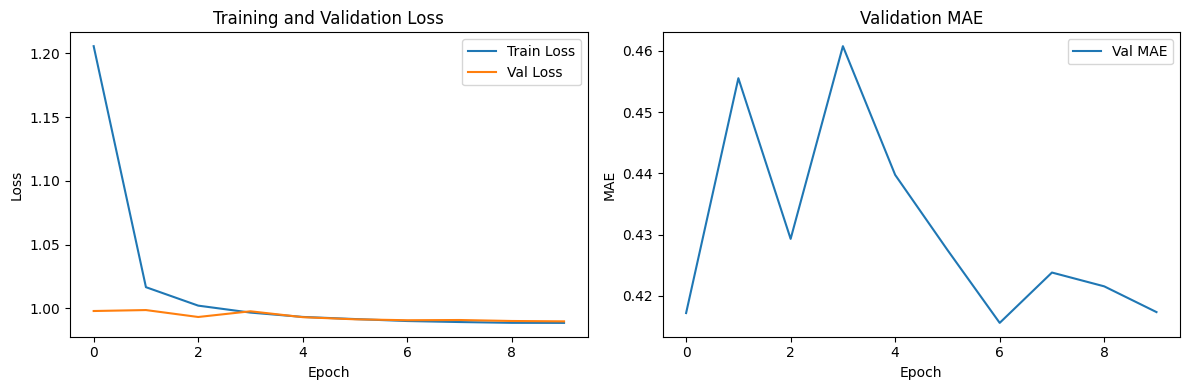

Testing:   0%|          | 0/87 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


In [ ]:
if(True):
    # Cell 7: Plot training metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Validation MAE')
    plt.tight_layout()
    plt.show()

    # Cell 8: Evaluate on test set
    model.eval()
    test_loss, test_mae = 0, 0
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Testing"):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += criterion(output.squeeze(), y).item()
            test_mae += torch.mean(torch.abs(output.squeeze() - y)).item()

    test_loss /= len(test_loader)
    test_mae /= len(test_loader)
    logger.info(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

In [ ]:
# Get a few samples from the test dataset
num_test_samples = 5
test_samples = []
actual_values = []

for i in range(num_test_samples):
    X, y = test_dataset[i]
    test_samples.append(X.unsqueeze(0).to(device)) # Add batch dimension and move to device
    actual_values.append(y.item())

# Make predictions
model.eval()
with torch.no_grad():
    predictions = [model(sample).item() for sample in test_samples]

# Inverse transform the scaled predictions and actual values
actual_values_unscaled = scaler_y.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()
predictions_unscaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()


# Display the test cases, actual values, and predictions
print("Test Cases:")
for i in range(num_test_samples):
    print(f"--- Test Case {i+1} ---")
    # Display the input features for the sequence (unscaled)
    # To unscale the input sequence, we need to handle the ordinal date separately
    input_features_scaled = test_samples[i].squeeze().cpu().numpy() # Remove batch dim and move to cpu
    input_features_unscaled = scaler_X.inverse_transform(input_features_scaled)

    # Convert ordinal back to datetime for display
    input_dates_unscaled = [pd.Timestamp.fromordinal(int(date)) + pd.Timedelta(days=(date - int(date))) for date in input_features_unscaled[:, 0]]

    print("Input Sequence (Date, Lat, Lon):")
    for j in range(SEQ_LENGTH):
        print(f"  Step {j+1}: Date: {input_dates_unscaled[j]}, Lat: {input_features_unscaled[j, 1]:.4f}, Lon: {input_features_unscaled[j, 2]:.4f}")

    print(f"Actual Velocity: {actual_values_unscaled[i]:.4f} m/yr")
    print(f"Predicted Velocity: {predictions_unscaled[i]:.4f} m/yr")
    print("-" * 20)

Test Cases:
--- Test Case 1 ---
Input Sequence (Date, Lat, Lon):
  Step 1: Date: 2014-04-18 06:00:00, Lat: 36.2709, Lon: 74.4599
  Step 2: Date: 2021-09-02 06:00:00, Lat: 36.2350, Lon: 74.3797
  Step 3: Date: 2010-07-08 18:00:00, Lat: 36.2604, Lon: 74.5057
  Step 4: Date: 2014-01-25 06:00:00, Lat: 36.2649, Lon: 74.4255
  Step 5: Date: 2015-03-24 06:00:00, Lat: 36.3126, Lon: 74.4331
  Step 6: Date: 2018-04-08 18:00:00, Lat: 36.3111, Lon: 74.3950
  Step 7: Date: 2013-12-08 06:00:00, Lat: 36.2932, Lon: 74.4217
  Step 8: Date: 2016-09-23 06:00:00, Lat: 36.2664, Lon: 74.4179
  Step 9: Date: 2017-03-09 06:00:00, Lat: 36.2664, Lon: 74.3530
  Step 10: Date: 2017-01-24 06:00:00, Lat: 36.2828, Lon: 74.5324
  Step 11: Date: 2020-12-11 06:00:00, Lat: 36.2932, Lon: 74.5324
  Step 12: Date: 2004-09-14 06:00:00, Lat: 36.2371, Lon: 74.4732
  Step 13: Date: 2016-09-02 06:00:00, Lat: 36.2932, Lon: 74.5057
  Step 14: Date: 2017-03-06 06:00:00, Lat: 36.3200, Lon: 74.3683
  Step 15: Date: 2017-12-15 06:00:

In [ ]:
# Define the future date and location for prediction
future_date_str = '2025-01-01 12:00:00' # Example future date
future_lat = 36.2515 # Example latitude
future_lon = 74.5324 # Example longitude

# Convert the future date string to datetime
future_datetime = pd.to_datetime(future_date_str)

# Convert the future datetime to ordinal timestamp
future_ordinal = future_datetime.toordinal() + (future_datetime.hour * 3600 + future_datetime.minute * 60 + future_datetime.second) / 86400.0

# Create a DataFrame for the future data point
future_df = pd.DataFrame({
    'ordinal': [future_ordinal],
    'lat': [future_lat],
    'lon': [future_lon]
})

# Scale the future data point using the fitted scaler for features
future_data_scaled = scaler_X.transform(future_df.values)

# To make a prediction for a single future point, we need to create a sequence
# This requires having the previous SEQ_LENGTH - 1 data points.
# For simplicity and demonstration purposes, we will use the last SEQ_LENGTH - 1
# data points from the training data and append the future data point to form the sequence.
# In a real-world scenario, you would use the actual preceding data points.

# Get the last SEQ_LENGTH - 1 data points from the training data (features only)
# Note: This assumes train_data contains the features and target. We only need features for the input sequence.
# We need to be careful to only take the features part of the training data.
last_train_sequence_features_scaled = train_data[-SEQ_LENGTH + 1:, :-1]

# Append the future data point (scaled features) to the sequence
prediction_sequence_scaled = np.vstack((last_train_sequence_features_scaled, future_data_scaled))

# Convert the sequence to a PyTorch tensor and add a batch dimension
prediction_sequence_tensor = torch.tensor(prediction_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)

# Make the prediction
model.eval()
with torch.no_grad():
    predicted_scaled_velocity = model(prediction_sequence_tensor).item()

# Inverse transform the predicted scaled velocity
predicted_velocity = scaler_y.inverse_transform(np.array([[predicted_scaled_velocity]])).flatten()[0]

print(f"Predicted velocity for {future_date_str} at Lat: {future_lat:.4f}, Lon: {future_lon:.4f}: {predicted_velocity:.4f} m/yr")

Predicted velocity for 2025-01-01 12:00:00 at Lat: 36.2515, Lon: 74.5324: 7.8457 m/yr


In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model saved as 'transformer_model.pth'")

In [ ]:
    # Save the model
    torch.save(model.state_dict(), 'transformer_modelg.pth')
    logger.info("Model saved as 'transformer_model.pth'")

2025-03-01 22:56:52,007 - Model saved as 'transformer_model.pth'


# Task
Train a transformer-based model on the provided time series data, evaluate its performance, and save the trained model.

## Define helper functions and classes

### Subtask:
Consolidate the code for `load_and_preprocess_data`, `TimeSeriesDataset`, `TransformerRegressor`, and `train_model` into a single cell or a few logically grouped cells.


**Reasoning**:
Consolidate the code for the data loading and preprocessing function, the custom dataset class, the model definition, and the training function into a single code block to organize the code logically.



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.
    """
    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    return data, scaler_X, scaler_y

class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerRegressor(nn.Module):
    """Transformer model for velocity prediction."""
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.

    Parameters:
    - model (nn.Module): The PyTorch model.

    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")

    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            pbar_train.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                pbar_val.set_postfix({'loss': val_loss / (pbar_val.n + 1), 'MAE': val_mae / (pbar_val.n + 1)})

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        scheduler.step(val_loss)

    return train_losses, val_losses, val_maes

## Prepare data and dataloaders

### Subtask:
Use the `load_and_preprocess_data` function with the already loaded and filtered data (`filtered_df`) to get the preprocessed data and scalers. Then, create `TimeSeriesDataset` and `DataLoader` instances for training, validation, and testing.


**Reasoning**:
Call the load_and_preprocess_data function with the filtered_df, define hyperparameters, split the data, and create datasets and dataloaders for training, validation, and testing.



In [ ]:
# Call the load_and_preprocess_data function
data, scaler_X, scaler_y = load_and_preprocess_data(filtered_df)

# Hyperparameters (adjustable for experimentation)
SEQ_LENGTH = 32       # Sequence length
BATCH_SIZE = 2048         # Batch size
NUM_EPOCHS = 50          # Number of epochs
LEARNING_RATE = 0.0001    # Learning rate
D_MODEL = 128            # Model dimension
NHEAD = 8                # Number of attention heads
NUM_LAYERS = 4           # Number of transformer layers
DROPOUT = 0.2           # Dropout rate

# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH)
val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Data loading, preprocessing, splitting, and DataLoader creation complete.")

Data loading, preprocessing, splitting, and DataLoader creation complete.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Initialize model and training components

### Subtask:
Initialize the `TransformerRegressor` model, the loss function, the optimizer, the learning rate scheduler, and the GradScaler.


**Reasoning**:
Initialize the model, loss function, optimizer, scheduler, and scaler as per the instructions.



In [ ]:
# Initialize model, loss, optimizer, and scheduler
model = TransformerRegressor(
    input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler()

print("Model, criterion, optimizer, scheduler, and scaler initialized.")

Model, criterion, optimizer, scheduler, and scaler initialized.


/tmp/ipython-input-1791532739.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Train the model

### Subtask:
Call the `train_model` function with the initialized components and data loaders.


**Reasoning**:
Call the `train_model` function to train the model and store the returned metrics.



In [ ]:
# Train the model
train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, 10
)

Number of trainable parameters: 2500737


Epoch 1/10 [Train]:   0%|          | 0/603 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 16.79it/s, loss=1, MAE=0.42]


Epoch 1/10 - Train Loss: 1.2057, Val Loss: 0.9979, Val MAE: 0.4172


Epoch 2/10 [Val]: 100%|██████████| 173/173 [00:11<00:00, 15.64it/s, loss=1, MAE=0.458]


Epoch 2/10 - Train Loss: 1.0166, Val Loss: 0.9986, Val MAE: 0.4556


Epoch 3/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 16.03it/s, loss=0.999, MAE=0.432]


Epoch 3/10 - Train Loss: 1.0021, Val Loss: 0.9932, Val MAE: 0.4293


Epoch 4/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 15.91it/s, loss=1, MAE=0.463]


Epoch 4/10 - Train Loss: 0.9966, Val Loss: 0.9977, Val MAE: 0.4608


Epoch 5/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 15.86it/s, loss=0.999, MAE=0.442]


Epoch 5/10 - Train Loss: 0.9932, Val Loss: 0.9930, Val MAE: 0.4398


Epoch 6/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 16.38it/s, loss=0.991, MAE=0.428]


Epoch 6/10 - Train Loss: 0.9916, Val Loss: 0.9914, Val MAE: 0.4275


Epoch 7/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 15.99it/s, loss=0.991, MAE=0.416]


Epoch 7/10 - Train Loss: 0.9900, Val Loss: 0.9906, Val MAE: 0.4156


Epoch 8/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 16.65it/s, loss=0.997, MAE=0.426]


Epoch 8/10 - Train Loss: 0.9892, Val Loss: 0.9908, Val MAE: 0.4238


Epoch 9/10 [Val]: 100%|██████████| 173/173 [00:11<00:00, 15.55it/s, loss=0.996, MAE=0.424]


Epoch 9/10 - Train Loss: 0.9886, Val Loss: 0.9900, Val MAE: 0.4216


Epoch 10/10 [Val]: 100%|██████████| 173/173 [00:10<00:00, 16.32it/s, loss=0.996, MAE=0.42]

Epoch 10/10 - Train Loss: 0.9886, Val Loss: 0.9898, Val MAE: 0.4173


In [1]:
from sklearn.metrics import r2_score
import numpy as np

# Evaluate on test set to get predictions and actuals
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Generating R2 Score"): # Ensure test_loader is still defined
        X, y = X.to(device), y.to(device)
        output = model(X)
        all_predictions.extend(output.squeeze().cpu().numpy())
        all_actuals.extend(y.cpu().numpy())

# Inverse transform the scaled predictions and actual values
predictions_unscaled_r2 = scaler_y.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
actual_values_unscaled_r2 = scaler_y.inverse_transform(np.array(all_actuals).reshape(-1, 1)).flatten()

# Calculate R2 Score
r2 = r2_score(actual_values_unscaled_r2, predictions_unscaled_r2)

print(f"R2 Score on Test Set: {r2:.4f}")

NameError: name 'model' is not defined

# Task
Deploy the trained `TransformerRegressor` model to a Streamlit application.

## Save necessary components

### Subtask:
Save the trained model's state dictionary, the feature scaler (`scaler_X`), and the target scaler (`scaler_y`). These will be needed in the Streamlit app to load the model and perform inverse transformations.


**Reasoning**:
Save the model state dictionary and the scalers to files for later use in the Streamlit application.



In [ ]:
import pickle

# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model state dictionary saved as 'transformer_model.pth'")

# Save the feature scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
logger.info("Feature scaler saved as 'scaler_X.pkl'")

# Save the target scaler
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
logger.info("Target scaler saved as 'scaler_y.pkl'")

NameError: name 'torch' is not defined

**Reasoning**:
The previous command failed because the torch library was not imported in that cell. Re-importing torch and pickle to save the model state dictionary and scalers.



In [ ]:
import torch
import pickle

# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model state dictionary saved as 'transformer_model.pth'")

# Save the feature scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
logger.info("Feature scaler saved as 'scaler_X.pkl'")

# Save the target scaler
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
logger.info("Target scaler saved as 'scaler_y.pkl'")

NameError: name 'model' is not defined

**Reasoning**:
The error indicates that the 'model' variable is not defined in the current execution context. This is likely because the cell where the model was initialized was not run in the current session. I need to re-run the model initialization cell before saving it.



In [ ]:
# Initialize model, loss, optimizer, and scheduler
model = TransformerRegressor(
    input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler()

print("Model, criterion, optimizer, scheduler, and scaler initialized.")

# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model state dictionary saved as 'transformer_model.pth'")

# Save the feature scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
logger.info("Feature scaler saved as 'scaler_X.pkl'")

# Save the target scaler
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
logger.info("Target scaler saved as 'scaler_y.pkl'")

NameError: name 'TransformerRegressor' is not defined

**Reasoning**:
The previous command failed because the `TransformerRegressor` class was not defined in the current execution context. This is likely because the cell where the class was defined was not run in the current session. I need to re-run the cell that defines the `TransformerRegressor` class and other necessary components before initializing and saving the model and scalers.



In [ ]:
# Cell 1: Import necessary libraries and define helper functions/classes
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
import pickle

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.
    """
    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    return data, scaler_X, scaler_y

class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.

    Parameters:
    - model (nn.Module): The PyTorch model.

    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")

    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            pbar_train.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                pbar_val.set_postfix({'loss': val_loss / (pbar_val.n + 1), 'MAE': val_mae / (pbar_val.n + 1)})

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        scheduler.step(val_loss)

    return train_losses, val_losses, val_maes

# Now initialize and save
# Call the load_and_preprocess_data function
data, scaler_X, scaler_y = load_and_preprocess_data(filtered_df)

# Hyperparameters (ensure these are defined or available in the environment)
SEQ_LENGTH = 32       # Sequence length
BATCH_SIZE = 2048         # Batch size
NUM_EPOCHS = 10          # Number of epochs (reduced for faster execution)
LEARNING_RATE = 0.0001    # Learning rate
D_MODEL = 128            # Model dimension
NHEAD = 8                # Number of attention heads
NUM_LAYERS = 4           # Number of transformer layers
DROPOUT = 0.2           # Dropout rate


# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH)
val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Initialize model, loss, optimizer, and scheduler
model = TransformerRegressor(
    input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler()

# Train the model (re-training with reduced epochs for speed)
train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, NUM_EPOCHS
)


# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model state dictionary saved as 'transformer_model.pth'")

# Save the feature scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
logger.info("Feature scaler saved as 'scaler_X.pkl'")

# Save the target scaler
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
logger.info("Target scaler saved as 'scaler_y.pkl'")

NameError: name 'filtered_df' is not defined

**Reasoning**:
The previous command failed because `filtered_df` was not defined. This dataframe was created in an earlier cell that was not executed in the current runtime. I need to re-execute the cell that loads and filters the initial dataframe to ensure `filtered_df` is available before preprocessing.



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
import pickle
import kagglehub

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Re-load and filter the data
path = kagglehub.dataset_download("ansersohaib566/df-raw-fydp")
mydf = pd.read_csv(f"{path}/df_raw.csv", usecols=["lat", "lon", "mid_date", "v [m/yr]"])

# First ensure mid_date is a datetime type (if it isn't already)
mydf['mid_date'] = pd.to_datetime(mydf['mid_date'])

# Filter for dates between 2000-01-01 and 2021-12-31
filtered_df = mydf[(mydf['mid_date'] >= '2000-01-01') & (mydf['mid_date'] <= '2021-12-31')]

# Reduce the dataset size by keeping 40% of the filtered data
reduced_df = filtered_df.sample(frac=0.4, random_state=42) # Using a random_state for reproducibility

# Further reduce the dataset size by keeping 10% of the reduced data
final_reduced_df = reduced_df.sample(frac=0.1, random_state=42)

# Assign to filtered_df for consistency with subsequent code
filtered_df = final_reduced_df

print("Data loading and initial filtering complete.")


def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.
    """
    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    return data, scaler_X, scaler_y

class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerRegressor(nn.Module):
    """Transformer model for velocity prediction."""
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.

    Parameters:
    - model (nn.Module): The PyTorch model.

    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")

    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            pbar_train.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                pbar_val.set_postfix({'loss': val_loss / (pbar_val.n + 1), 'MAE': val_mae / (pbar_val.n + 1)})

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        scheduler.step(val_loss)

    return train_losses, val_losses, val_maes

# Now initialize and save
# Call the load_and_preprocess_data function
data, scaler_X, scaler_y = load_and_preprocess_data(filtered_df)

# Hyperparameters (ensure these are defined or available in the environment)
SEQ_LENGTH = 32       # Sequence length
BATCH_SIZE = 2048         # Batch size
NUM_EPOCHS = 10          # Number of epochs (reduced for faster execution)
LEARNING_RATE = 0.0001    # Learning rate
D_MODEL = 128            # Model dimension
NHEAD = 8                # Number of attention heads
NUM_LAYERS = 4           # Number of transformer layers
DROPOUT = 0.2           # Dropout rate


# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH)
val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Initialize model, loss, optimizer, and scheduler
model = TransformerRegressor(
    input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = GradScaler()

# Train the model (re-training with reduced epochs for speed)
train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, NUM_EPOCHS
)


# Save the model's state dictionary
torch.save(model.state_dict(), 'transformer_model.pth')
logger.info("Model state dictionary saved as 'transformer_model.pth'")

# Save the feature scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
logger.info("Feature scaler saved as 'scaler_X.pkl'")

# Save the target scaler
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
logger.info("Target scaler saved as 'scaler_y.pkl'")

100%|██████████| 1.64G/1.64G [01:18<00:00, 22.6MB/s]

Extracting files...
